# Renewable Energy Systems (RES) project 
### Aarhus University - Fall 2020
#### Frederik Giessing Nielsen 201608565
This notebook includes the steps to optimize the capacity and dispatch of generators in the power system of one country.
For the project of the course Renewable Energy Systems (RES) you need to deliver a report including the sections described at the end of this notebook.

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

In [2]:
df_elec = pd.read_csv('data_frederik/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec = df_elec['CHE'] #only 2015
df_solar = pd.read_csv('data_frederik/pv_optimal.csv', sep=';', index_col=0)
df_onshorewind = pd.read_csv('data_frederik/onshore_wind_1979-2017.csv', sep=';', index_col=0)

In this analysis Run of the river aswell as Hydroreosivoir electricity generation, will be included.

*Insert describtion of data find*

In [3]:
#For RoR:
CF_ror_month=[0.34,0.25,0.33,0.46,0.66,0.72,0.68,0.59,0.45,0.34,0.27,0.26]
df_ror=pd.DataFrame(CF_ror_month,columns=['CHE'], index=pd.date_range(start='2015-01-01',end='2015-12-31',freq='M')) #Convert list to pandas dataframe with months in 2015 as index
#Upsample from months to hours, with all hours in months being equal to the monthly values.
df_ror=df_ror.reindex(pd.date_range(start='2015-01-01',end='2015-12-31T23:00',freq='H'), method='bfill')

#For Hydrores
CF_hydrores_month=[0.34,0.35,0.24,0.21,0.33,0.39,0.36,0.28,0.30,0.36,0.32,0.27]
df_hydrores=pd.DataFrame(CF_hydrores_month,columns=['CHE'], index=pd.date_range(start='2015-01-01',end='2015-12-31',freq='M')) #Convert list to pandas dataframe with months in 2015 as index
#Upsample from months to hours, with all hours in months being equal to the monthly values.
df_hydrores=df_hydrores.reindex(pd.date_range(start='2015-01-01',end='2015-12-31T23:00',freq='H'), method='bfill')

df_ror.iloc[8737:8760]=df_ror.iat[8736,0]
df_hydrores.iloc[8737:8760]=df_hydrores.iat[8736,0]

#df to series
df_ror=df_ror.squeeze()
df_hydrores=df_hydrores.squeeze()


We start by creating the network. In this example, the country is modelled as a single node, so the network will only include one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case, Switzerland (CHE), and add one node (electricity bus) to the network.

In [4]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H')
network.set_snapshots(hours_in_2015)

network.add("Bus","electricity bus")

In [5]:
# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec)

In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [6]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

The cost assumed for the generators are the same as in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf).

Add generators to the network, onshorewind, PV, aswell as run-of-river and gas turbine:

In [7]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "Hydro inflow")

# add onshore wind generator

CF_wind = df_onshorewind['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add solar PV generator

CF_solar = df_solar['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)
###########
df_ror.index=CF_solar.index
df_hydrores.index=CF_solar.index
############
#add run-of-river generator
#CF_ror = df_ror['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_ror = annuity(80,0.07)*3000000*(1+0.02) # in €/MW
network.add("Generator",
            "ror",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="ror",
            p_nom_max=4162,
            capital_cost = capital_cost_ror,
            p_max_pu = df_ror)

#add Hydro reservoir/hydro storage generator
#CF_hydrores = df_hydrores['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_hydrores = annuity(80,0.07)*2000000*(1+0.01) # in €/MW

network.add("Generator",
            "hydrores",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="hydrores",
            p_nom_max=8224,
            capital_cost = capital_cost_hydrores,
            p_max_pu = df_hydrores)
            

We solve the linear optimal power flow (lopf) using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [ ]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

The total cost can be read from the network objetive.

In [ ]:
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/float(network.loads_t.p.sum()))) # €/MWh

The optimal capacity for every generator can be shown.

In [ ]:
network.generators.p_nom_opt # in MW

We can plot now the dispatch of every generator and the electricity demand, during the first week and a summer week of the year.


In [19]:
def plotdispatch(a,b,title="None"):
    
    plt.plot(network.loads_t.p['load'][a:b], color='black', label='demand')
    plt.plot(network.generators_t.p['onshorewind'][a:b], color='purple', label='onshore wind')
    plt.plot(network.generators_t.p['solar'][a:b], color='orange', label='solar')
    plt.plot(network.generators_t.p['OCGT'][a:b], color='brown', label='gas (OCGT)')
    plt.plot(network.generators_t.p['ror'][a:b], color='blue', label='Run-of-river')
    plt.plot(network.generators_t.p['hydrores'][a:b], color='cyan', label='Hydro reservoir')
    plt.legend(fancybox=True, shadow=True, loc='upper right')
    plt.ylabel('Dispatch (MW)')
    
    if title=="None":
        plt.title('Dispatch throught the hours {} to {}'.format(a,b))
    else:
        plt.title(title)
    
    plt.show()

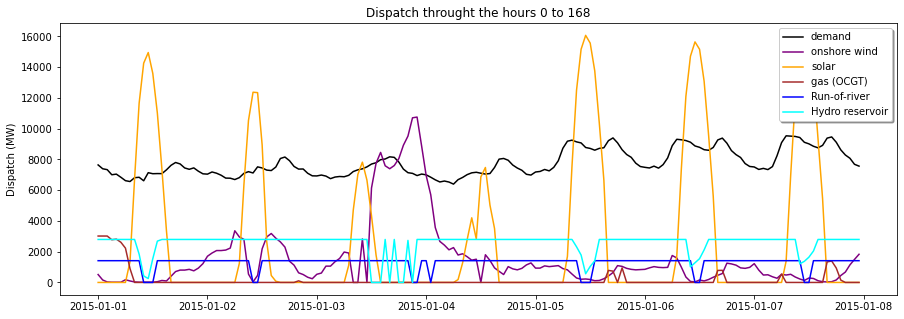

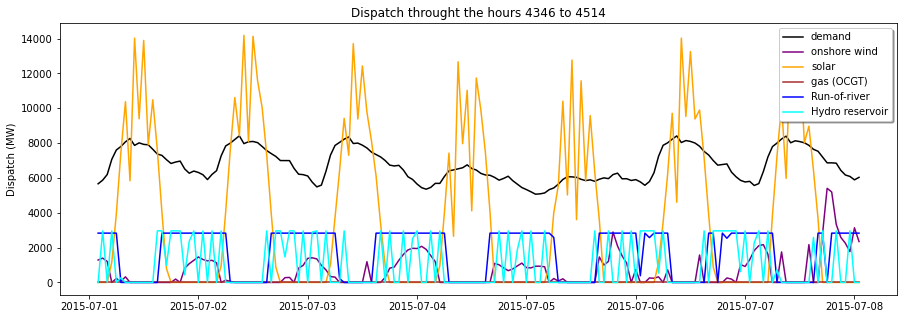

In [20]:
plotdispatch(0,168)
plotdispatch(4346,4346+168)

We can also plot the electricity mix.

In [ ]:
def elecmix(title="None"):
    labels = ['onshore wind', 
              'solar', 
              'gas (OCGT)',
              'Run-of-river',
              'Hydro reservoir']
    sizes = [network.generators_t.p['onshorewind'].sum(),
             network.generators_t.p['solar'].sum(),
             network.generators_t.p['OCGT'].sum(),
             network.generators_t.p['ror'].sum(),
             network.generators_t.p['hydrores'].sum()]

    colors=['purple', 'yellow', 'brown', 'blue','cyan']

    plt.pie(sizes, 
            colors=colors, 
            labels=labels, 
            wedgeprops={'linewidth':0})
    plt.axis('equal')

    if title == 'None':
        plt.title('Electricity mix', y=1.07)
    else:
        plt.title(title)
    plt.show()
    

In [48]:
elecmix()

NameError: name 'elecmix' is not defined

In [ ]:
mymodule.cfplot(CF_wind,CF_solar)

We can add a global CO2 constraint and solve again.

A. Choose a different country/region and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution from different technologies. 

In [9]:
co2_limit=4000000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

In [ ]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

In [ ]:
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/float(network.loads_t.p.sum()))) # €/MWh

In [ ]:
network.generators.p_nom_opt # in MW

In [ ]:
plotdispatch(0,168)
plotdispatch(4346,4346+168)

In [ ]:
elecmix()

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer the emissions allowance to that historical data.

In [ ]:
def co2sens():
    TCOS=[]#Total cost of system in 10^6 €
    df_p_nom = pd.DataFrame(columns=network.generators.p_nom_opt.index) #initialise dataframe with generators as columns
    df_elecmix=pd.DataFrame(columns=network.generators.p_nom_opt.index)
    
    #co2list=[10000]
    #co2list.extend(np.linspace(500000,5500000,num=5))
    co2list=np.linspace(500000,5500000,num=5)
    for i in co2list:
        network.global_constraints.constant=i #Set Co2 contraint to i

        network.lopf(network.snapshots, 
                 solver_name='gurobi')
        
        df_p_nom.loc[i] = network.generators.p_nom_opt.values
        TCOS.append(network.objective/1000000)
        df_elecmix.loc[i]=network.generators_t.p.sum().values
    df_p_nom['TCOS']=TCOS
    return(df_p_nom,df_elecmix)

In [ ]:
df_p_nom,df_elecmix=co2sens()

In [ ]:
df_p_nom.head()
df_elecmix.head()

Lets add the historic CO2 values emitted by electricity generation.

*Source: https://www.iea.org/data-and-statistics?country=SWITLAND&fuel=CO2%20emissions&indicator=CO2EleBySource*

In [ ]:
co2_1990=1*10**6
co2_2015=0.5*10**6

In [ ]:
colors=['purple', 'orange', 'brown', 'blue','cyan','black']

def plotoptcap():
    for i,name  in enumerate(df_p_nom.columns):
        plt.plot(df_p_nom.index,df_p_nom[name],label=name,color=colors[i])
    plt.legend(fancybox=True, shadow=True, loc='upper right')
    plt.xlabel('CO2-constraint (ton CO2)')
    plt.ylabel('Optimum installed capicity (MW)')
    plt.title("Optimum installed capacity as a function of CO2-constraint")
    #plt.yscale('log')
    plt.axvline(x=co2_1990,color='k',ls='--',lw='0.7')
    plt.axvline(x=co2_2015,color='k',ls='--',lw='0.7')
    plt.text(co2_1990,plt.ylim()[1]-0.1*plt.ylim()[1],'CO2 1990',rotation=0)
    plt.text(co2_2015,plt.ylim()[1]-0.1*plt.ylim()[1],'CO2 2015',rotation=0)
    
    plt.show()
def plotelecmix():
    for i,name  in enumerate(df_elecmix.columns):
        percent=df_elecmix[name]/network.generators_t.p.sum().values.sum()*100 #relaculate to %
        plt.plot(df_elecmix.index,percent,label=name,color=colors[i])
    plt.legend(fancybox=True, shadow=True, loc='upper right')
    plt.xlabel('CO2-constraint (ton CO2)')
    plt.ylabel('% of electricity mix')
    plt.title("Electricity mix as a function of CO2-constraint")
    
    plt.axvline(x=co2_1990,color='k',ls='--',lw='0.7')
    plt.axvline(x=co2_2015,color='k',ls='--',lw='0.7')
    plt.text(co2_1990,plt.ylim()[1]-0.1*plt.ylim()[1],'CO2 1990',rotation=0)
    plt.text(co2_2015,plt.ylim()[1]-0.1*plt.ylim()[1],'CO2 2015',rotation=0)
    
    plt.show()

plotoptcap()
plotelecmix()

In [80]:
import mymodule
import importlib
importlib.reload(mymodule);


C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

In [ ]:
years,df_optcap = mymodule.intanvar(2014,2015,network,df_elec,df_onshorewind,df_solar,df_ror,df_hydrores,500000);

In [ ]:
print("Overvies of optimal capacities through different year \n",df_optcap)

In [ ]:
mymodule.intanvarplot(df_optcap,network,colors,years)

D. Add some storage technology/ies and investigate how they behave and what is their impact on the optimal system configuration.

In [15]:

#Add pumped hydro storage
#Assumptions: Power delivery is equal both ways, and max hours is propertional to nominal power
capital_cost_PHS = annuity(80,0.07)*2000000*(1+0.01) # in €/MW
network.add("StorageUnit",
            "PHS",
            bus="electricity bus",
            p_nom_extendable=False,
            p_nom=1380, #https://link.springer.com/article/10.1007/s40565-016-0239-y
            max_hours=369000/1380, #Capacity/nominal power 
            carrier="PHS",
            efficiency_store=0.87,
            efficiency_dispatch=0.87,
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_PHS
            )

#Add battery storage
network.add("Bus","battery bus")

capital_cost_battery = annuity(15,0.07)*144600*(1+0.00) # in €/MW
network.add("Store",
            "Battery",
            bus="battery bus",
            e_nom_extendable=True,
            capital_cost = capital_cost_battery
           )
#dispatch link
capital_cost_batterylink1 = annuity(20,0.07)*310000*(1+0.03) # in €/MW
network.add("Link",
            "batterylink1",
            bus0="battery bus",
            bus1="electricity bus",
            capital_cost=capital_cost_batterylink1,
            p_nom_extendable=True,
            efficiency=0.87
           )
                    
#store link
capital_cost_batterylink2=annuity(20,0.07)*310000*(1+0.03) # in €/MW
network.add("Link",
            "batterylink2",
            bus1="battery bus",
            bus0="electricity bus",
            p_nom_extendable=True,
            capital_cost=capital_cost_batterylink2,
            efficiency=0.87
            )

In [16]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x105129_copy
  Lower bound: 5284810397.844296
  Upper bound: 5284810397.844296
  Number of objectives: 1
  Number of constraints: 183962
  Number of variables: 105129
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 105129
  Number of nonzeros: 389835
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [17]:
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/float(network.loads_t.p.sum()))) # €/MWh.

Total cost of system is 5284.81 mio. € 
Total cost of system pr. MWh is 85.16 €


In [47]:
print(network.generators.p_nom_opt)
print(network.storage_units.p_nom_opt)
print("Optimal electric battery capacity is {} MWh"network.stores.e_nom_opt.value())
print(network.links.p_nom_opt)


onshorewind    16077.292509
solar          26606.213384
OCGT            3018.494232
ror             4162.000000
hydrores        8224.000000
Name: p_nom_opt, dtype: float64
PHS    1380.0
Name: p_nom_opt, dtype: float64
Battery    34849.033912
Name: e_nom_opt, dtype: float64
batterylink1    2791.963563
batterylink2    6704.180300
Name: p_nom_opt, dtype: float64


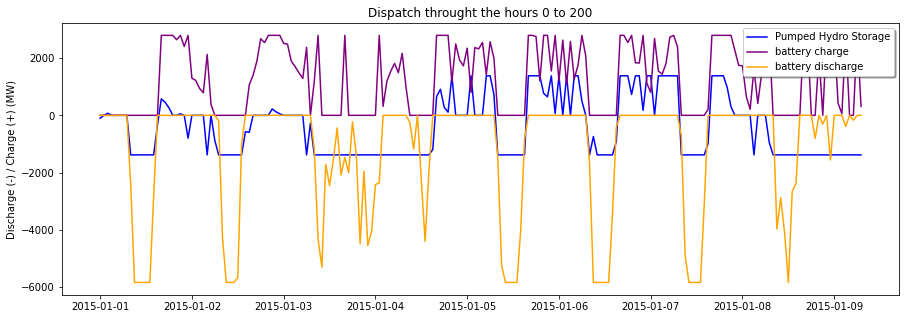

In [45]:
mymodule.plotstorage(0,200,network)

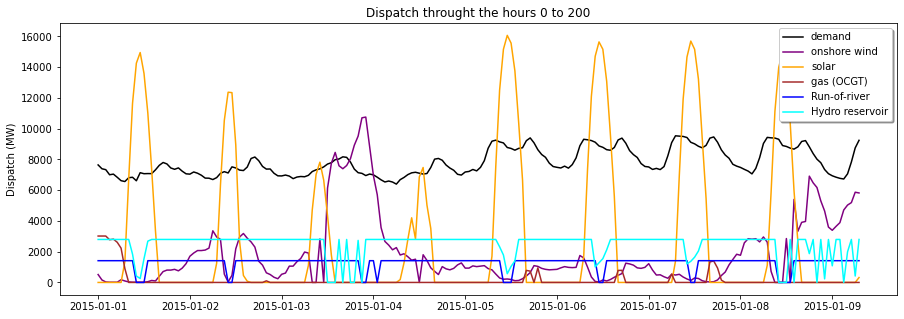

In [46]:
plotdispatch(0,200)

E. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.) 

F. Select on target for decarbonizatio (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your result. 

G. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimize the whole system. You can also include fixed interconnection capacities or cooptimize them with the generators capacities. Discuss your results.

In [ ]:
#Add battery storage
network.add("Bus","Germany bus")
#network.add("Bus","Italy bus")
network.add("Bus","France bus")
#network.add("Bus","Austria bus")

#Germany link
#capital_cost_germanylink = annuity(20,0.07)*310000*(1+0.03) # in €/MW
network.add("Link",
            "germanylink",
            bus0="electricity bus",
            bus1="Germany bus",
            #capital_cost=capital_cost_germanylink,
            p_nom_extendable=True,
            efficiency=1
            p_min_pu = -1
           )
